<a href="https://colab.research.google.com/github/cheatham1/EU-JAV-ItalianTweetStance/blob/main/VaccineAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bertopic

In [2]:
import spacy
from bertopic import BERTopic

In [3]:
!pip install spacy

In [4]:
import numpy as np
import pandas as pd
import csv
import re
import datetime

In [5]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
#stop = stopwords.words('english')
stop = stopwords.words('italian')

#new_stopwords = ["all", "due", "to", "on", "daily", "the", "and", "of", "to", "in", "for", "we", "that","the","&amp","-"]

new_stopwords = ["user","link"]
stop.extend(new_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
data_dates = pd.read_csv(
    "https://raw.githubusercontent.com/cheatham1/EU-JAV-DATA/main/db_sett21_n%3D1-800.tsv",
    sep='\t', names=["created_at","text","label"]
)

data_dates = data_dates.iloc[1:]
print("dataset: ",data_dates.shape[0])

dataset:  800


In [7]:
data_dates.text = data_dates.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
data_dates.text = data_dates.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
data_dates.text = data_dates.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)

data_dates.text = data_dates.loc[:,'text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
data_dates.text = data_dates['text'].str.replace('[^\w\s]','',regex=True)

data_dates['created_at']   = data_dates['created_at'].apply(pd.to_datetime)
data_dates['YearMonthDay'] = data_dates['created_at'].apply(lambda x:x.strftime('%Y%m%d'))
data_dates['YearMonth']    = data_dates['created_at'].apply(lambda x:x.strftime('%Y%m'))
data_dates['YearMonth']    = data_dates['YearMonth']+"01"

total_data = data_dates.copy()

In [8]:
# Remove 2 ambiguous, 5 indiscernible and 6 not applicable

total_data.label = total_data.label.astype('Int64')

total_data.drop( total_data[ total_data['label'] == 2].index, inplace=True)
total_data.drop( total_data[ total_data['label'] == 5].index, inplace=True)
total_data.drop( total_data[ total_data['label'] == 6].index, inplace=True)

# 0 = promotional, 1 = netral, 2 = discouraging

total_data['label'] = total_data['label'].replace(1, 0) # promotional
total_data['label'] = total_data['label'].replace(4, 1) # neutral
total_data['label'] = total_data['label'].replace(3, 2) # discouraging

print("dataset: ",total_data.shape[0])

dataset:  571


In [9]:
total_data.groupby(['label']).count()

,created_at,text,YearMonthDay,YearMonth
label,,,,
0,185,185,185,185
1,206,206,206,206
2,180,180,180,180


In [10]:
#test_data_A = pd.read_csv(
#    "https://raw.githubusercontent.com/FrGes/EU-JAV/main/datasetA_test_3categories.csv",
#    names=["Annotator1","Annotator2","Annotator3","label", "text","index"]
#)

#test_data_B = pd.read_csv(
#    "https://raw.githubusercontent.com/FrGes/EU-JAV/main/datasetB_test_3categories.csv",
#    names=["Annotator1","Annotator2","Annotator3","label", "text","index"]
#)
#total_data = test_data_A.append(test_data_B)
#total_data = total_data[["label","text"]]
#total_data.columns = ["label","text"]
#
#print("Total dataset: ",total_data.shape[0],": datasetA: ", test_data_A.shape[0], " datasetB:", test_data_B.shape[0])


In [11]:
### Look at length tweets
total_data['n_words'] = [len(x.split()) for x in total_data['text'].tolist()]
#total_data.loc[(total_data['n_words']<5)]

# remove tweets < 5 words
total_data.drop(total_data[ total_data['n_words']<5 ].index, inplace=True)
total_data.drop('n_words', axis=1, inplace=True)

total_data.groupby(['label']).count()

,created_at,text,YearMonthDay,YearMonth
label,,,,
0,169,169,169,169
1,195,195,195,195
2,169,169,169,169


In [12]:
data_promotional = total_data[ total_data['label'] == 0 ].copy()
data_neutral = total_data[ total_data['label'] == 1 ].copy()
data_discouraging = total_data[ total_data['label'] == 2 ].copy()

print("promotional: ",data_promotional.shape[0],": neutral: ", data_neutral.shape[0], " discouraging:", data_discouraging.shape[0])
print("Total = ", data_promotional.shape[0]+ data_neutral.shape[0]+ data_discouraging.shape[0])

promotional:  169 : neutral:  195  discouraging: 169
Total =  533


In [13]:
data_promotional.head()

,created_at,text,label,YearMonthDay,YearMonth
1,2021-05-06 18:44:21+00:00,generale figliuolo dovrebbe chiedere scusa pop...,0,20210506,20210501
8,2021-04-08 12:45:12+00:00,dati nuova campagnavaccinale testimoniano camb...,0,20210408,20210401
11,2021-08-22 13:58:42+00:00,covid continua colpire neonati tre casi vicent...,0,20210822,20210801
16,2021-04-26 07:05:04+00:00,mario draghi rifiuta vaccino sostenga costi pr...,0,20210426,20210401
17,2021-03-14 08:47:32+00:00,rt covid figliuolo obiettivo vaccinati entro e...,0,20210314,20210301


In [14]:
data_promotional['text'] = data_promotional.loc[:,'text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
data_discouraging['text'] = data_discouraging.loc[:,'text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))

data_promotional['text'] = data_promotional['text'].str.replace('[^\w\s]','',regex=True)
data_discouraging['text'] = data_discouraging['text'].str.replace('[^\w\s]','',regex=True)

Tweet_promotional = data_promotional.text
Tweet_discouraging = data_discouraging.text


In [15]:
from collections import Counter

word_count_p = Counter(" ".join(Tweet_promotional).split()).most_common(50)
word_frequency_p = pd.DataFrame(word_count_p, columns = ['Word', 'Frequency: promotional'])

n_tweets_p = len(word_frequency_p)
word_frequency_p["Promotional"] =  word_frequency_p["Frequency: promotional"]/n_tweets_p

print(word_frequency_p)

            Word  Frequency: promotional  Promotional
0        vaccino                      62         1.24
1        vaccini                      45         0.90
2             no                      32         0.64
3      vaccinati                      30         0.60
4             pi                      23         0.46
5      vaccinato                      21         0.42
6          covid                      19         0.38
7           fare                      18         0.36
8          perch                      15         0.30
9          novax                      14         0.28
10           vax                      14         0.28
11        essere                      13         0.26
12         senza                      12         0.24
13  vaccinazione                      12         0.24
14         altri                      11         0.22
15          anni                      11         0.22
16          dose                       9         0.18
17        quindi            

In [16]:
word_count_d = Counter(" ".join(Tweet_discouraging).split()).most_common(50)
word_frequency_d = pd.DataFrame(word_count_d, columns = ['Word', 'Frequency: discouraging'])

n_tweets_d = len(word_frequency_d)
word_frequency_d["Discouraging"] =  word_frequency_d["Frequency: discouraging"]/n_tweets_d

print(word_frequency_d)

            Word  Frequency: discouraging  Discouraging
0        vaccino                       72          1.44
1        vaccini                       50          1.00
2          covid                       30          0.60
3      vaccinati                       29          0.58
4             pi                       22          0.44
5          perch                       18          0.36
6   vaccinazione                       14          0.28
7           cosa                       14          0.28
8           dopo                       13          0.26
9          fatto                       13          0.26
10     vaccinato                       12          0.24
11           poi                       12          0.24
12        essere                       11          0.22
13            no                       11          0.22
14          solo                       11          0.22
15        ancora                       10          0.20
16         stato                       10       

In [17]:
import functools as ft
dfs = [word_frequency_d,word_frequency_p]
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='Word'), dfs)

df_final

,Word,Frequency: discouraging,Discouraging,Frequency: promotional,Promotional
0,vaccino,72,1.44,62,1.24
1,vaccini,50,1.00,45,0.90
2,covid,30,0.60,19,0.38
3,vaccinati,29,0.58,30,0.60
4,pi,22,0.44,23,0.46
5,perch,18,0.36,15,0.30
6,vaccinazione,14,0.28,12,0.24
7,cosa,14,0.28,7,0.14
8,fatto,13,0.26,8,0.16
9,vaccinato,12,0.24,21,0.42


In [18]:
df_final.columns

Index(['Word', 'Frequency: discouraging', 'Discouraging',
       'Frequency: promotional', 'Promotional'],
      dtype='object')

[Text(0.5, 0, 'Word count'),
 Text(0, 0.5, 'Key words'),
 Text(0.5, 1.0, 'Key word count in promotional tweets')]

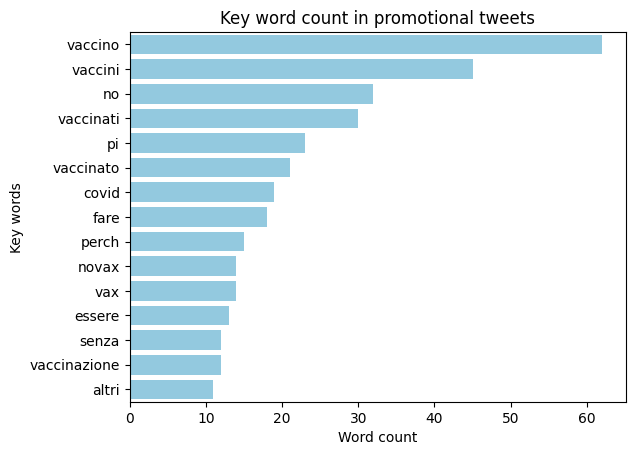

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt = sns.barplot(word_frequency_p.head(15), y="Word", x = "Frequency: promotional", color = "skyblue")
plt.set(xlabel ="Word count", ylabel = "Key words", title ='Key word count in promotional tweets')


[Text(0.5, 0, 'Word count'),
 Text(0, 0.5, 'Key words'),
 Text(0.5, 1.0, 'Key word count in discouraging tweets')]

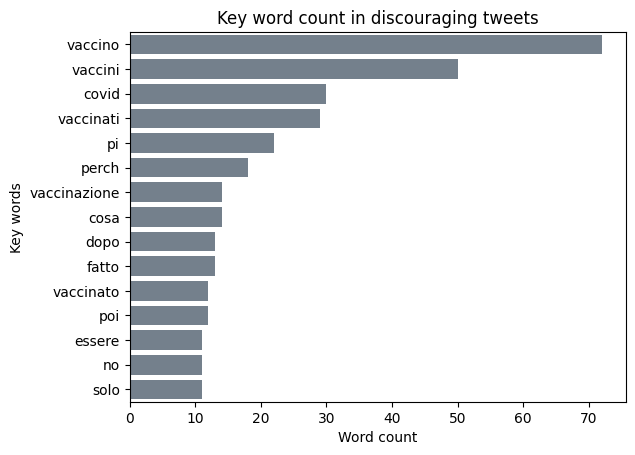

In [20]:
plt = sns.barplot(word_frequency_d.head(15), y="Word", x = "Frequency: discouraging", color = "slategrey")
plt.set_title("Key word count in discouraging tweets")
plt.set(xlabel ="Word count", ylabel = "Key words", title ='Key word count in discouraging tweets')


In [21]:
df_final.head()

,Word,Frequency: discouraging,Discouraging,Frequency: promotional,Promotional
0,vaccino,72,1.44,62,1.24
1,vaccini,50,1.00,45,0.90
2,covid,30,0.60,19,0.38
3,vaccinati,29,0.58,30,0.60
4,pi,22,0.44,23,0.46


In [22]:
df=df_final[["Word","Discouraging", "Promotional"]]

df.set_index('Word', inplace=True)
df = df.stack().to_frame('word frequency in tweet').reset_index()
df.rename(columns={'level_1':'Stance'},inplace=True)

df.head()

,Word,Stance,word frequency in tweet
0,vaccino,Discouraging,1.44
1,vaccino,Promotional,1.24
2,vaccini,Discouraging,1.00
3,vaccini,Promotional,0.90
4,covid,Discouraging,0.60


<Axes: xlabel='word frequency in tweet', ylabel='Word'>

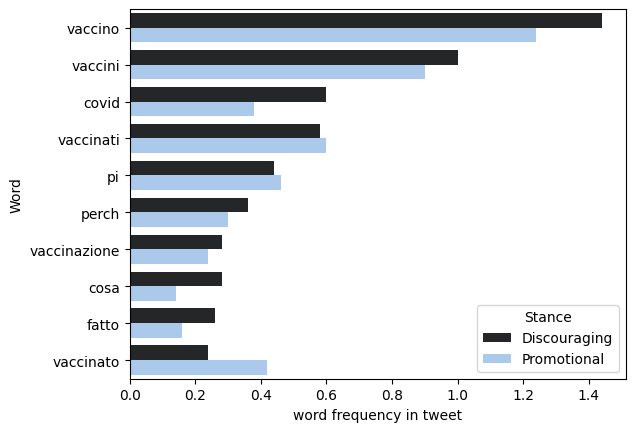

In [23]:
sns.set_color_codes("pastel")

sns.barplot(data=df.head(20), y='Word', x='word frequency in tweet', hue='Stance', color="b", orient = 'h')

In [24]:
df_final.head()

,Word,Frequency: discouraging,Discouraging,Frequency: promotional,Promotional
0,vaccino,72,1.44,62,1.24
1,vaccini,50,1.00,45,0.90
2,covid,30,0.60,19,0.38
3,vaccinati,29,0.58,30,0.60
4,pi,22,0.44,23,0.46


In [25]:
df_final["Ratio"] = df_final.Discouraging/ df_final.Promotional
df_final_sorted = df_final.sort_values(by=['Ratio'], ascending=False)

df_final_sorted.head()

,Word,Frequency: discouraging,Discouraging,Frequency: promotional,Promotional,Ratio
7,cosa,14,0.28,7,0.14,2.000000
10,poi,12,0.24,7,0.14,1.714286
8,fatto,13,0.26,8,0.16,1.625000
2,covid,30,0.60,19,0.38,1.578947
20,detto,8,0.16,6,0.12,1.333333


<Axes: xlabel='Ratio', ylabel='Word'>

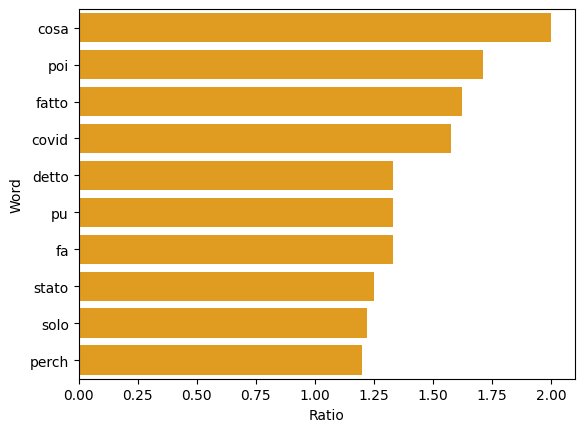

In [26]:
sns.barplot(data=df_final_sorted.head(10), y='Word', x='Ratio', color="orange", orient = 'h')

In [27]:
!pip install KeyBERT

In [28]:
# Use LLM to extract keywords
from keybert import KeyBERT

docs_p = ' '.join(data_promotional['text'].tolist())
docs_d = ' '.join(data_discouraging['text'].tolist())

# Extract keywords
kw_model_p = KeyBERT()
keywords_p = kw_model_p.extract_keywords(docs_p)

kw_model_d = KeyBERT()
keywords_d = kw_model_d.extract_keywords(docs_d)

print("Promotional keywords: ", keywords_p)
print("Discouraging keywords: ", keywords_d)

Promotional keywords:  [('vaccinazione', 0.5908), ('vaccinatevi', 0.561), ('nonvaccinati', 0.5362), ('vaccinatori', 0.5291), ('vaccinato', 0.5259)]
Discouraging keywords:  [('vaccinato', 0.4528), ('vaccinazione', 0.4524), ('vaccinoaigiornalisti', 0.4364), ('vaccinano', 0.4262), ('vaccinata', 0.4231)]


In [29]:
def extract_vocab(keywords):
  vocab = []

  for i in range(len(keywords)):
    (vocabulary, score) = keywords[i]
    vocab.append(vocabulary)

  return(vocab)

In [30]:
vocab_p = extract_vocab(keywords_p)
print("Promotional vocab:", vocab_p)

vocab_d = extract_vocab(keywords_d)
print("Discouraging vocab:", vocab_d)


Promotional vocab: ['vaccinazione', 'vaccinatevi', 'nonvaccinati', 'vaccinatori', 'vaccinato']
Discouraging vocab: ['vaccinato', 'vaccinazione', 'vaccinoaigiornalisti', 'vaccinano', 'vaccinata']


In [31]:
!pip install wordcloud

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image    # to import the image

In [33]:
Tweet_discouraging.head()

6     laboratori militari prassi sviluppare parallel...
21    nessunacorrelazione quindi vaccinoaigiornalist...
23    sicuramente accetter mai pfizer fin ora letto ...
25    vaccino futuro iniettare petrolio pur poter to...
33    esperti sanno nulla vaccini ancora fase sperim...
Name: text, dtype: object

In [34]:
discouraging_text = ",".join(str(element) for element in Tweet_discouraging)
promotional_text = ",".join(str(element) for element in Tweet_promotional)

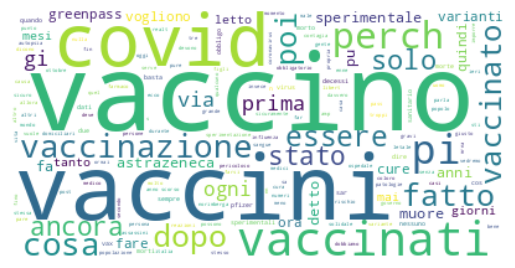

In [35]:
wordcloud = WordCloud(background_color='white').generate(discouraging_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

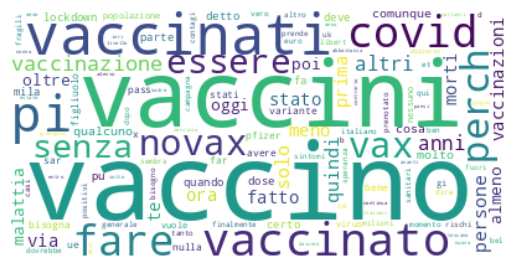

In [36]:
wordcloud = WordCloud(background_color='white').generate(promotional_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
word_frequency_d.head()

,Word,Frequency: discouraging,Discouraging
0,vaccino,72,1.44
1,vaccini,50,1.00
2,covid,30,0.60
3,vaccinati,29,0.58
4,pi,22,0.44


In [38]:
!pip install squarify

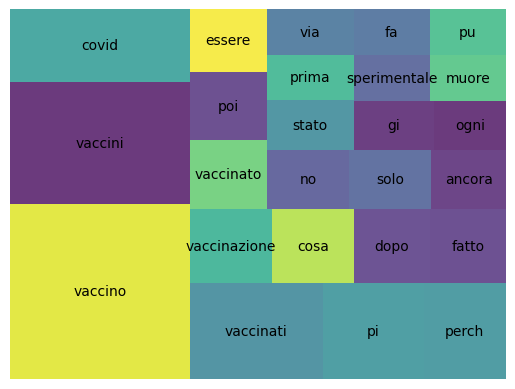

In [39]:
# libraries
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd

# Create a data frame with fake data
#df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })

df = word_frequency_d.head(25)
# plot it
squarify.plot(sizes=df['Discouraging'], label=df['Word'], alpha=.8 )
plt.axis('off')
plt.show()

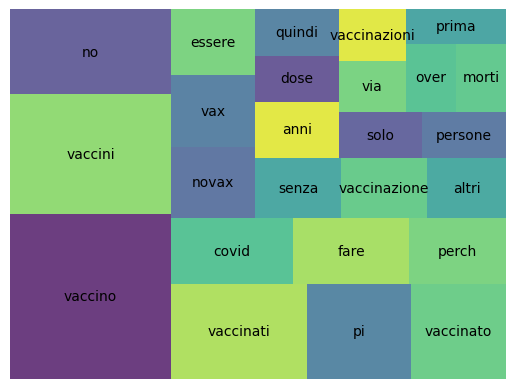

In [40]:
df = word_frequency_p.head(25)
# plot it
squarify.plot(sizes=df['Promotional'], label=df['Word'], alpha=.8 )
plt.axis('off')
plt.show()

In [41]:
# Text summarization

In [42]:
#!pip install --upgrade transformers

In [43]:
#!pip install sentencepiece

In [44]:
#import transformers


In [45]:
#import torch

In [46]:
# Summariyation models
#'BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration',
#'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'LEDForConditionalGeneration',
#'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration',
#'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'PegasusForConditionalGeneration', 'PLBartForConditionalGeneration',
#'ProphetNetForConditionalGeneration', 'T5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'].

#from transformers import T5Tokenizer, T5ForConditionalGeneration

##tokenizer = T5Tokenizer.from_pretrained('t5-small')
#model = T5ForConditionalGeneration.from_pretrained('t5-small')
##tokenizer = T5Tokenizer.from_pretrained('t5-base')
#model = T5ForConditionalGeneration.from_pretrained('t5-base')

In [47]:
#data_discouraging['Tweet'].head()

In [48]:
#input_text = data_discouraging.Tweet.str.cat(sep=' ')

In [49]:
#from transformers import pipeline

#tokenizer.encode(input_text, return_tensors='pt', max_length=2400, truncation=True)
#summarizer = pipeline("summarization", model = model, tokenizer= tokenizer)
#summarizer(input_text)

In [50]:
#data1 = pd.read_csv(
 #   "https://raw.githubusercontent.com/cheatham1/EU-JAV-DATA/main/no_replies_no_mentions_dataset1_5categories.csv",
 #   header = None)

#data2 = pd.read_csv(
#    "https://raw.githubusercontent.com/cheatham1/EU-JAV-DATA/main/no_replies_no_mentions_dataset2_5categories.csv",
#    header = None)


In [51]:
#total_data5 = pd.concat([data1, data2])

#print("Total dataset: ",total_data5.shape[0],": dataset1: ", data1.shape[0], " dataset2:", data2.shape[0])

In [52]:
#total_data5.columns = ["label","Tweet"]
#total_data5.head()

In [53]:
#data5_promotional = total_data5[ total_data5['label'] == 0 ].copy()
#data5_neutral = total_data5[ total_data5['label'] == 1 ].copy()
#data5_discouraging = total_data5[ total_data5['label'] == 2 ].copy()

#n_promotional5 = data5_promotional.shape[0]
##n_neutral5 = data5_neutral.shape[0]
#n_discouraging5 = data5_discouraging.shape[0]

#print("promotional: ",n_promotional5,": neutral: ",n_neutral5 , " discouraging:", n_discouraging5)
#print("Total = ", n_promotional5+ n_neutral5+ n_discouraging5)

In [54]:
#data5_promotional['Tweet'] = data5_promotional.loc[:,'Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
#data5_discouraging['Tweet'] = data5_discouraging.loc[:,'Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))

#data5_promotional['Tweet'] = data5_promotional['Tweet'].str.replace('[^\w\s]','',regex=True)
###data5_discouraging['Tweet'] = data5_discouraging['Tweet'].str.replace('[^\w\s]','',regex=True)

#Tweet5_promotional = data5_promotional.Tweet
#Tweet5_discouraging = data5_discouraging.Tweet

In [55]:
#total_data5['Tweet'] = total_data5.loc[:,'Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
#total_data5['Tweet'] = total_data5['Tweet'].str.replace('[^\w\s]','',regex=True)
#total_data5_tweets = total_data5.Tweet


In [56]:
# Just promotional, neutral and discouraging
#total_data3 = pd.concat([data5_promotional, data5_neutral, data5_discouraging])
#total_data3['Tweet'] = total_data3.loc[:,'Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
##total_data3['Tweet'] = total_data3['Tweet'].str.replace('[^\w\s]','',regex=True)
#total_data3_tweets = total_data3.Tweet

In [57]:
#total_data3_tweets.head()

In [105]:
total_data_tweets = total_data.text

topic_model = BERTopic(language="italian", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(total_data_tweets)


2024-04-02 09:56:57,106 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2024-04-02 09:57:17,163 - BERTopic - Embedding - Completed ✓
2024-04-02 09:57:17,169 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-02 09:57:21,318 - BERTopic - Dimensionality - Completed ✓
2024-04-02 09:57:21,321 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-02 09:57:21,370 - BERTopic - Cluster - Completed ✓
2024-04-02 09:57:21,377 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-02 09:57:21,428 - BERTopic - Representation - Completed ✓


In [106]:
fig = topic_model.visualize_topics()
fig.show()

# Topic -1  corresponds to outliers
# By default, BERTopic uses HDBSCAN for clustering, and it doesn’t force all data points to be part of clusters.

In [107]:
probs[0]

array([1.52873345e-308, 1.00000000e+000, 1.87641995e-308, 1.46184584e-308,
       1.66922306e-308, 1.56970120e-308, 3.30637616e-308, 1.85529857e-308,
       1.50484944e-308, 1.39052417e-308, 1.46734591e-308, 1.41325077e-308])

In [108]:
topic_model.get_topic(0)  # Select the most frequent topic

[('vaccini', 0.042660560275295696),
 ('vaccino', 0.039688211655570085),
 ('rischio', 0.02837345266153804),
 ('malattia', 0.02837345266153804),
 ('vaccinati', 0.028305626265427593),
 ('cosa', 0.024725410436486062),
 ('quindi', 0.023466493701117315),
 ('decessi', 0.022540324384151152),
 ('covid', 0.022002819628273905),
 ('sperimentali', 0.02070798863051046)]

In [109]:
topic_model.visualize_barchart(top_n_topics=8)

In [110]:
topic_model.visualize_term_rank()

In [111]:
freq = topic_model.get_topic_info(); freq.head(15)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,236,-1_vaccino_vaccini_vaccinati_pi,"[vaccino, vaccini, vaccinati, pi, perch, no, c...",[insomma uk segue israele vuole introdurre pas...
1,0,65,0_vaccini_vaccino_rischio_malattia,"[vaccini, vaccino, rischio, malattia, vaccinat...",[eh no volessimo considerare varianti finora r...
2,1,29,1_italia_italiano_vaccino_vaccini,"[italia, italiano, vaccino, vaccini, europa, s...",[problema italia medico pu proporti fare dose ...
3,2,27,2_pfizer_vaccini_vaccino_moderna,"[pfizer, vaccini, vaccino, moderna, richiamo, ...",[video vaccinazioni frabosasottana cirio giova...
4,3,27,3_vaccini_vogliono_molto_senza,"[vaccini, vogliono, molto, senza, vaccino, qui...",[pensiero lamenta cessione vaccini stati pover...
5,4,27,4_vaccino_oggi_gi_nonna,"[vaccino, oggi, gi, nonna, fatto, militare, va...",[us vaccino davano canna cos pensavano pi oltr...
6,5,24,5_milioni_dosi_mila_milione,"[milioni, dosi, mila, milione, vaccinati, vacc...",[dati nuova campagnavaccinale testimoniano cam...
7,6,21,6_asl_vaccini_brescia_maggio,"[asl, vaccini, brescia, maggio, attivit, doman...",[bergamo brescia annuncio bertolaso domani vac...
8,7,20,7_novax_no_vax_libert,"[novax, no, vax, libert, far, tam, evitare, st...",[difficile far capire succede solo ricoverati ...
9,8,16,8_no_quando_prima_nobel,"[no, quando, prima, nobel, falsit, candidato, ...",[quando finiranno dire falsit hosempre detto s...


In [65]:
topic_model.get_topic(1)

[('pfizer', 0.05532498300710705),
 ('vaccino', 0.053850959579212765),
 ('pi', 0.04988639480116282),
 ('variante', 0.045725710081632745),
 ('vaccini', 0.04333948471260508),
 ('solidale', 0.0367953631859243),
 ('moderna', 0.034844186107267985),
 ('richiamo', 0.033333028888925004),
 ('uso', 0.033333028888925004),
 ('funziona', 0.03210018798700772)]

In [66]:
topic_model.get_topic(2)

[('italia', 0.07832274256899),
 ('italiano', 0.04845311394265316),
 ('vaccini', 0.04361206008815606),
 ('vaccino', 0.03810209404189582),
 ('europa', 0.02955103668062042),
 ('scelto', 0.0277700854233391),
 ('ogni', 0.026570758147715052),
 ('italiana', 0.026297498948881504),
 ('quando', 0.026107580856329995),
 ('solo', 0.02609844248843216)]

In [112]:
topic_model.visualize_hierarchy(top_n_topics=15)

In [113]:
hierarchical_topics = topic_model.hierarchical_topics(total_data_tweets)


100%|██████████| 11/11 [00:00<00:00, 145.21it/s]


In [114]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─vaccini_vaccino_covid_pi_dosi
│    ├─■──asl_vaccini_brescia_maggio_attivit ── Topic: 6
│    └─vaccini_vaccino_covid_vaccinati_pfizer
│         ├─vaccini_vaccino_milioni_vaccinati_dosi
│         │    ├─■──milioni_dosi_mila_milione_vaccinati ── Topic: 5
│         │    └─vaccini_vaccino_malattia_covid_pfizer
│         │         ├─■──vaccini_vaccino_rischio_malattia_vaccinati ── Topic: 0
│         │         └─■──pfizer_vaccini_vaccino_moderna_richiamo ── Topic: 2
│         └─■──muore_morte_covid_autopsia_dopo ── Topic: 11
└─vaccino_vaccini_no_novax_essere
     ├─■──insegnanti_scolastico_scuole_bambini_provateci ── Topic: 10
     └─vaccino_vaccini_novax_no_greenpass
          ├─■──novax_no_vax_libert_far ── Topic: 7
          └─vaccino_vaccini_greenpass_quando_italia
               ├─vaccino_vaccini_italia_quando_no
               │    ├─vaccino_no_me_gi_vita
               │    │    ├─■──no_quando_prima_nobel_falsit ── Topic: 8
               │    │    └─■──vaccino_oggi_gi_nonna_fatto 

In [70]:
# Calculate the topic distributions on a token-level
#topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

# Visualize the token-level distributions
#df = topic_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
#df

In [71]:
# Perhaps better in english
#from sentence_transformers import SentenceTransformer
#sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
#embeddings = sentence_model.encode(total_data3_tweets, show_progress_bar=False)

In [72]:
# Run the visualization with the original embeddings
#topic_model.visualize_hierarchical_documents(total_data3_tweets, hierarchical_topics, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:

###hierarchical_topics = topic_model.hierarchical_topics(total_data3_tweets)

#topic_model.visualize_hierarchical_documents(total_data3_tweets, hierarchical_topics)

In [115]:
topic_model.visualize_heatmap(n_clusters=2, width=800, height=800)

In [116]:
topic_model.visualize_heatmap(n_clusters=6, width=800, height=800)

In [117]:
topic_model.visualize_heatmap(width=800, height=800)

In [118]:
topic_model.visualize_distribution(probs[10], min_probability=0.0002)

In [119]:
topic_model.get_topic(10)

[('insegnanti', 0.07780221469029491),
 ('scolastico', 0.07780221469029491),
 ('scuole', 0.07780221469029491),
 ('bambini', 0.05580791977177963),
 ('provateci', 0.05580791977177963),
 ('pediatra', 0.05580791977177963),
 ('vaccinato', 0.05388996390243478),
 ('scuola', 0.051868143126863275),
 ('libro', 0.051868143126863275),
 ('stato', 0.049750372960639284)]

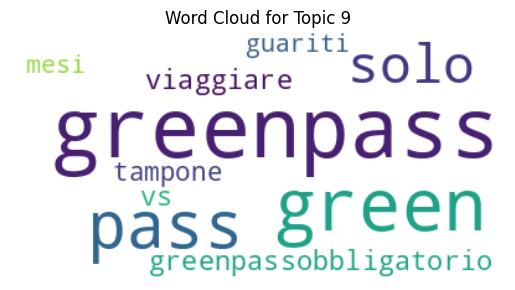

In [120]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    title = "Word Cloud for Topic "+ str(topic)
    plt.title(title)
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=9)

In [121]:
#topic_model3 = topic_model.reduce_topics(total_data_tweets, nr_topics=3)

#topics3 = topic_model3.topics_
#topic_model3.visualize_distribution(probs[10], min_probability=0.0002)

In [122]:
total_data_tweets

1      generale figliuolo dovrebbe chiedere scusa pop...
2      milioni over ancora vaccinati milioni over anc...
3      comunque dicendo cose diverse secondo me confr...
5      cts detto esattamente detto ema due giorni fa ...
6      laboratori militari prassi sviluppare parallel...
                             ...                        
796    ministero salute rezza immunit gregge quando v...
797    poi nessuno quei paesi comparabile provato agg...
798    via libera ema vaccino astrazeneca sicuro effi...
799    giorno qualcuno disse nessuno salva solo quind...
800    purtroppo vero italiani generale vaccino scett...
Name: text, Length: 533, dtype: object

In [81]:
#total_data_text_label = total_data[["text","label"]]
#total_data_text = total_data[["text"]]

In [123]:
# Create topic model and calculate topics per class

docs = total_data_tweets

target_names = ["promotional","neutral","discouraging"]
classes = [target_names[i] for i in total_data["label"]]

topics_per_class = topic_model.topics_per_class(docs, classes=classes)

#topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=3)
topic_model.visualize_topics_per_class(topics_per_class)

3it [00:00, 46.61it/s]


In [124]:
topics_class = topics_per_class.copy()

topics_class_no_outliers = topics_per_class.copy()
topics_class_no_outliers.drop(topics_class.loc[topics_class['Topic']==-1].index, inplace=True)

a = topics_class.groupby('Class')['Frequency'].transform('sum')
topics_class['Frequency_Normalised'] = topics_class['Frequency'].div(a)

a = topics_class_no_outliers.groupby('Class')['Frequency'].transform('sum')
topics_class_no_outliers['Frequency_Normalised'] = topics_class_no_outliers['Frequency'].div(a)

#topics_class.drop('Words', axis=1 , inplace=True)
#topics_class.drop('Name', axis=1 , inplace=True)
n_promotional = data_promotional.shape[0]
n_neutral     = data_neutral.shape[0]
n_discouraging = data_discouraging.shape[0]

print("Total = ", n_promotional, n_neutral, n_discouraging)

topics_class

Total =  169 195 169


,Topic,Words,Frequency,Class,Name,Frequency_Normalised
0,-1,"vaccinati, vaccino, no, vaccinato, vaccini",77,promotional,-1_vaccino_vaccini_vaccinati_pi,0.455621
1,0,"vaccino, malattia, vaccini, tetano, zero",22,promotional,0_vaccini_vaccino_rischio_malattia,0.130178
2,1,"italiano, vaccini, visto, italia, stato",7,promotional,1_italia_italiano_vaccino_vaccini,0.041420
3,2,"pfizer, cellulari, linee, vaccino, prima",8,promotional,2_pfizer_vaccini_vaccino_moderna,0.047337
4,3,"errori, caro, vaccini, essere, molto",7,promotional,3_vaccini_vogliono_molto_senza,0.041420
5,4,"vaccino, nonna, oggi, fare, zia",11,promotional,4_vaccino_oggi_gi_nonna,0.065089
6,5,"mila, milioni, abruzzo, dosi, mese",7,promotional,5_milioni_dosi_mila_milione,0.041420
7,6,"annuale, netto, espresso, aperto, francesco",2,promotional,6_asl_vaccini_brescia_maggio,0.011834
8,7,"novax, no, vax, libert, far",14,promotional,7_novax_no_vax_libert,0.082840
9,8,"no, me, falsit, parenti, lume",4,promotional,8_no_quando_prima_nobel,0.023669


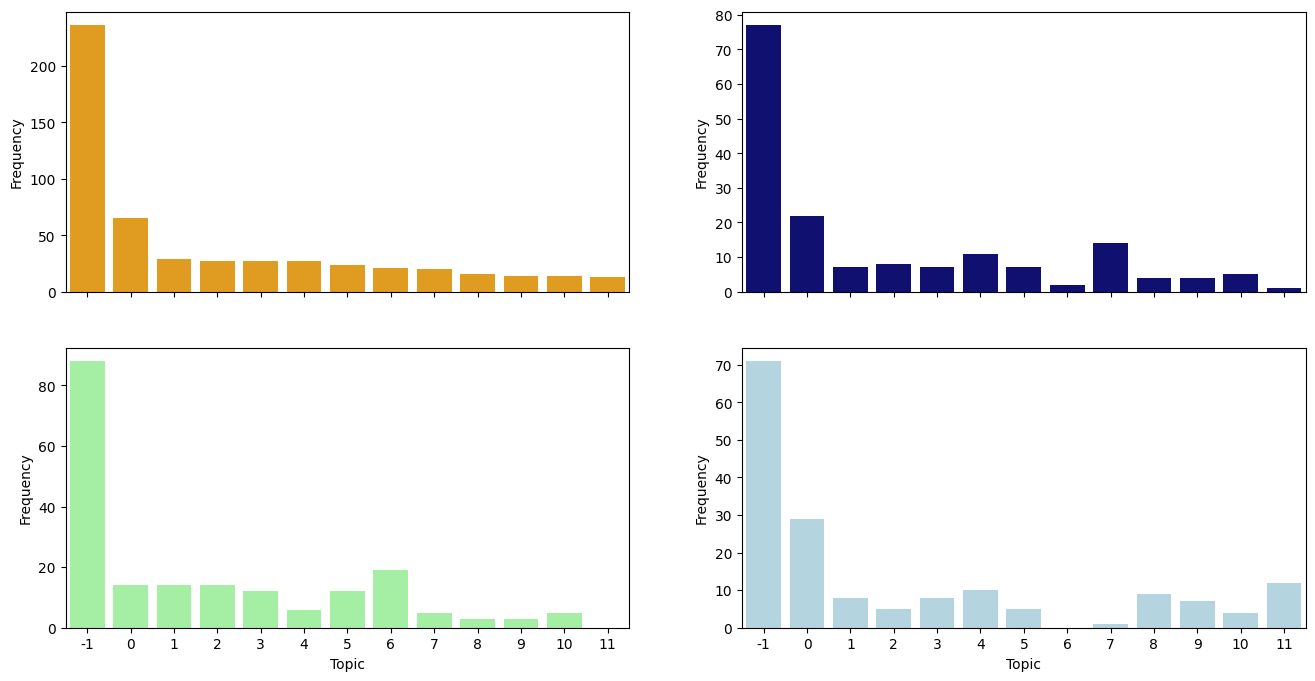

In [125]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 2, sharex=True, figsize=(16,8))

bar1 = sns.barplot(ax=axes[0, 0], x="Topic",  y="Frequency", data=topics_class, estimator=sum, ci=None,  color='orange')
#bar1.set(ylim=(0, 45))

promotional = topics_class[topics_class.Class == "promotional"]
bar2 = sns.barplot(ax=axes[0, 1], x="Topic",  y="Frequency", data=promotional, estimator=sum, ci=None,  color='navy')
#bar2.set(ylim=(0, 45))

neutral = topics_class[topics_class.Class == "neutral"]
bar3 = sns.barplot(ax=axes[1, 0], x="Topic",  y="Frequency", data=neutral, estimator=sum, ci=None,  color='palegreen')
#bar3.set(ylim=(0, 45))

discouraging = topics_class[topics_class.Class == "discouraging"]
bar4 = sns.barplot(ax=axes[1, 1], x="Topic",  y="Frequency", data=discouraging, estimator=sum, ci=None,  color='lightblue')
#bar4.set(ylim=(0, 45))



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

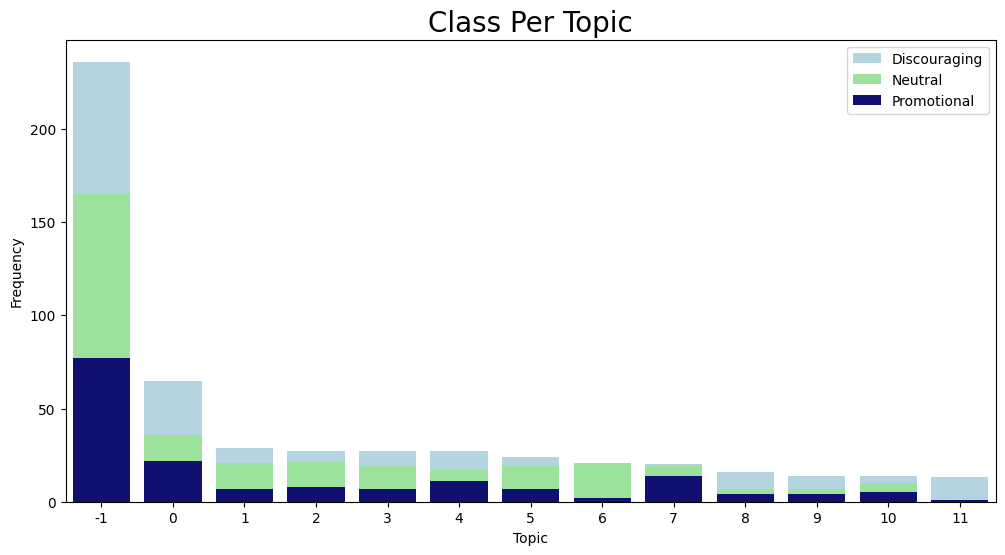

In [149]:
plt.figure(figsize=(12,6))

bar1 = sns.barplot(x="Topic",  y="Frequency", data=topics_class, estimator=sum, ci=None,  color='lightblue', label = "Discouraging").set(title='Class per Topic')

promotional_neutral = promotional.append(neutral)
bar3 = sns.barplot(x="Topic",  y="Frequency", data=promotional_neutral, estimator=sum, ci=None,  color='lightgreen', label = "Neutral")


bar2 = sns.barplot(x="Topic",  y="Frequency", data=promotional, estimator=sum, ci=None,  color='navy', label = "Promotional")

plt.title("Class Per Topic", fontsize=20)

from google.colab import files
plt.savefig("ClassPerTopic.png")
files.download("ClassPerTopic.png")

In [127]:
nTopics = topics_class.Topic.nunique()
nTopics

13

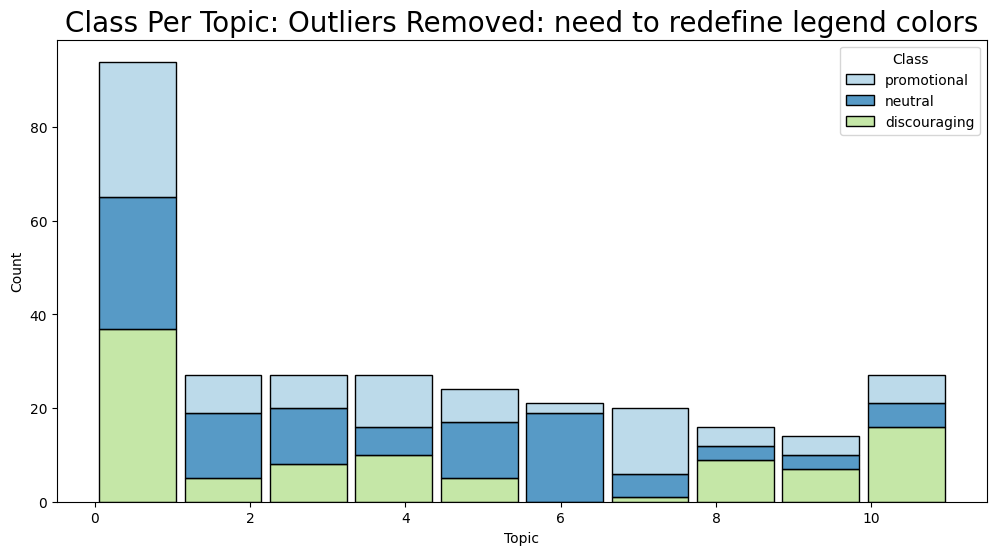

In [128]:
plt.figure(figsize=(12,6))

ax = sns.histplot(topics_class_no_outliers, x='Topic', hue='Class', weights='Frequency', multiple='stack', palette = sns.color_palette("Paired"), shrink=.9)
ax.set_title("Class Per Topic: Outliers Removed: need to redefine legend colors", fontsize=20)

bin_width = 0,9
min_val = -1
max_value = 12

ax.get_legend().set_visible(True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

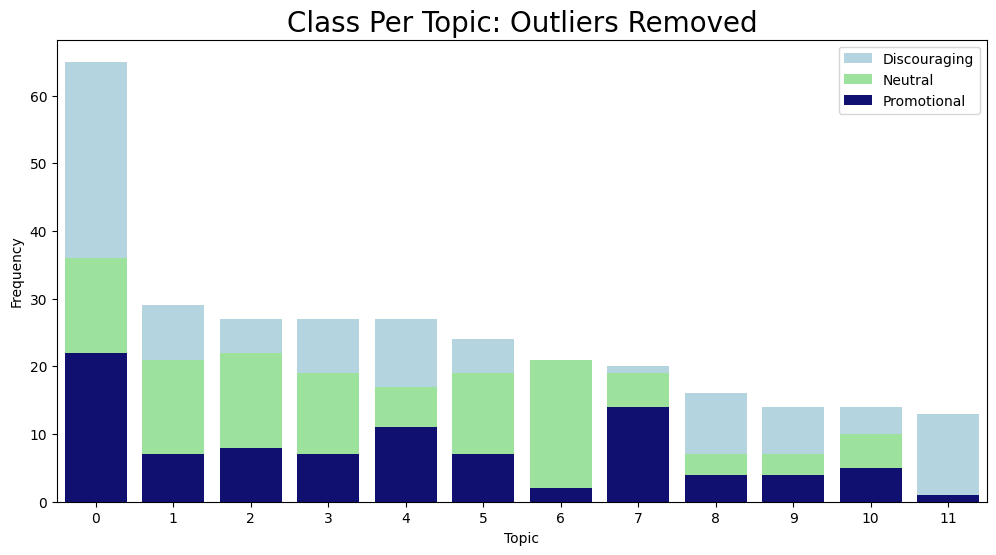

In [147]:
plt.figure(figsize=(12,6))

bar1 = sns.barplot(x="Topic",  y="Frequency", data=topics_class_no_outliers, estimator=sum, ci=None,  color='lightblue', label = "Discouraging").set(title='Class per Topic')

promotional_no = topics_class_no_outliers[topics_class_no_outliers.Class == "promotional"]
neutral_no = topics_class_no_outliers[topics_class_no_outliers.Class == "neutral"]
promotional_neutral_no = promotional_no.append(neutral_no)

bar3 = sns.barplot(x="Topic",  y="Frequency", data=promotional_neutral_no, estimator=sum, ci=None,  color='lightgreen', label = "Neutral")

bar2 = sns.barplot(x="Topic",  y="Frequency", data=promotional_no, estimator=sum, ci=None,  color='navy', label = "Promotional")

plt.title("Class Per Topic: Outliers Removed", fontsize=20)

#from google.colab import files
plt.savefig("ClassPerTopic_no_outliers.png")
files.download("ClassPerTopic_no_outliers.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

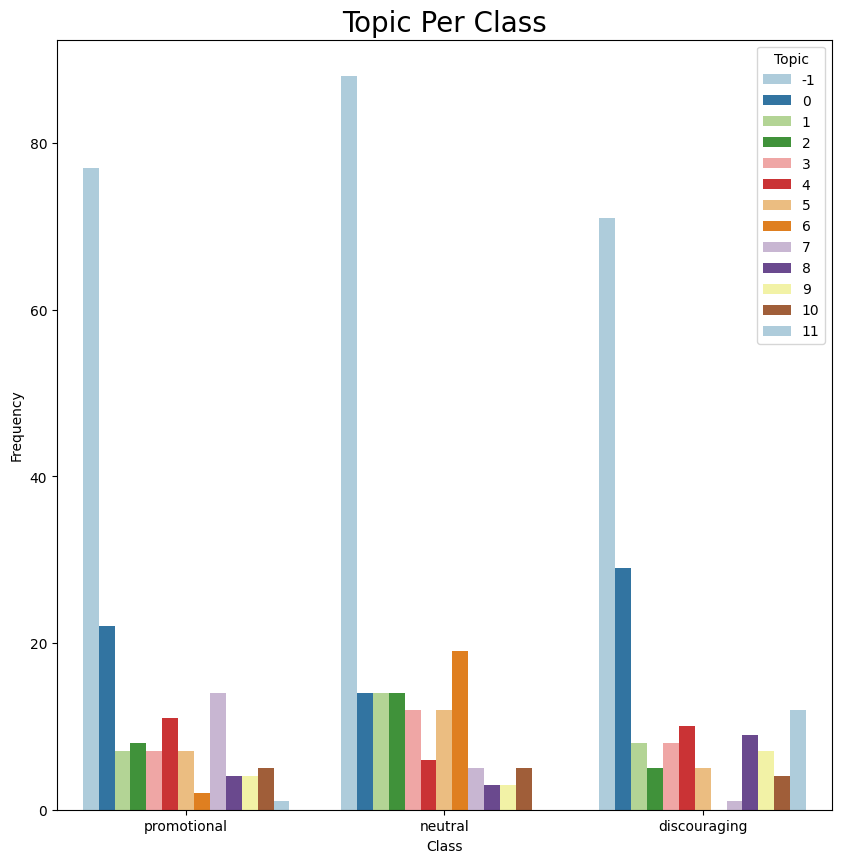

In [139]:
# Set the figure size
plt.figure(figsize=(10, 10))

sns.set_palette(sns.color_palette("Paired"))

# grouped barplot
ax = sns.barplot(
    x="Class",
    y="Frequency",
    hue="Topic",
    data=topics_class,
    ci=None,
    palette = sns.color_palette("Paired")
    )

# Customize the axes and title
ax.set_title("Topic Per Class", fontsize=20)
ax.set_ylabel("Frequency")

# Remove top and right borders
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

# Topic -1 = Outliers !!!!
plt.savefig("TopicPerClass.png")
files.download("TopicPerClass.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

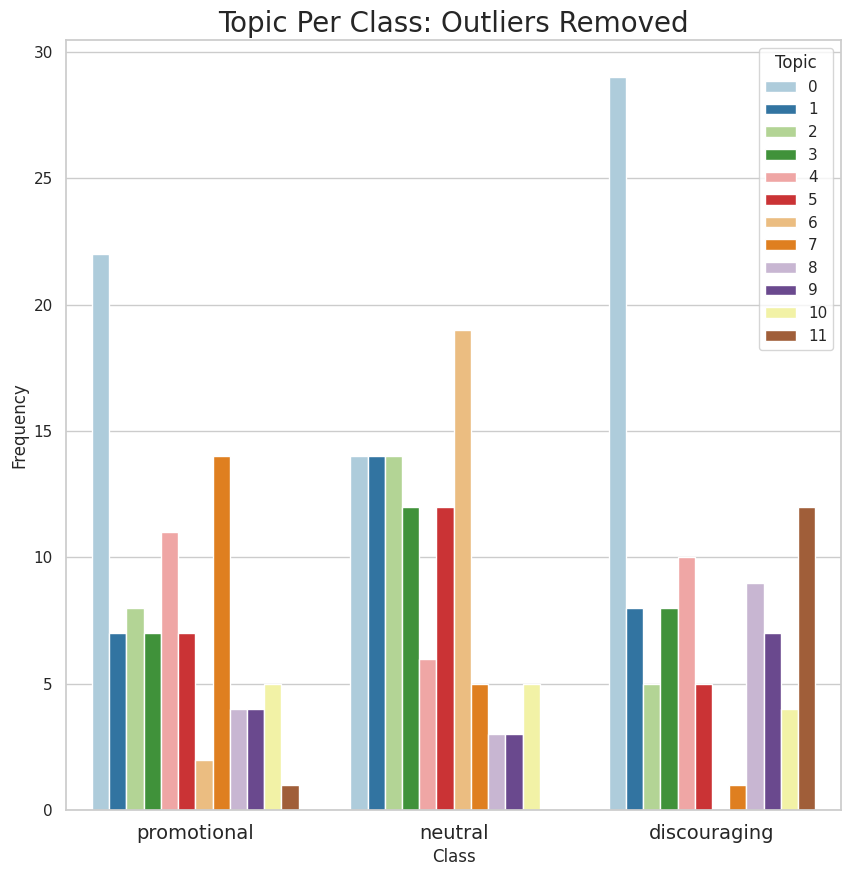

In [166]:
# Set the figure size
plt.figure(figsize=(10, 10))

sns.set_palette(sns.color_palette("Paired"))
sns.set_style("whitegrid")

# grouped barplot
ax = sns.barplot(
    x="Class",
    y="Frequency",
    hue="Topic",
    data=topics_class_no_outliers,
    ci=None,
    palette = sns.color_palette("Paired")
    )

# Customize the axes and title
ax.set_title("Topic Per Class: Outliers Removed", fontsize=20)
#sns.set(font_scale = 1)

plt.tick_params(axis='x', which='major', labelsize=14)

ax.set_ylabel("Frequency")

# Topic -1 = Outliers !!!!
plt.savefig("TopicPerClass_no_outliers.png")
files.download("TopicPerClass_no_outliers.png")

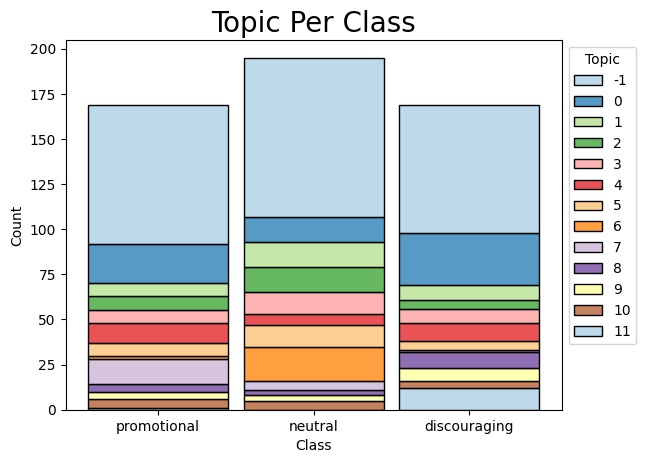

In [154]:
width = 0.8

ax = sns.histplot(topics_class, x='Class', hue='Topic', weights='Frequency', multiple='stack', palette = sns.color_palette("Paired"), shrink=.9)
ax.set_title("Topic Per Class", fontsize=20)

#ax.get_legend().set_visible(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#plt.savefig("TopicPerClassStacked.png")
#files.download("TopicPerClassStacked.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

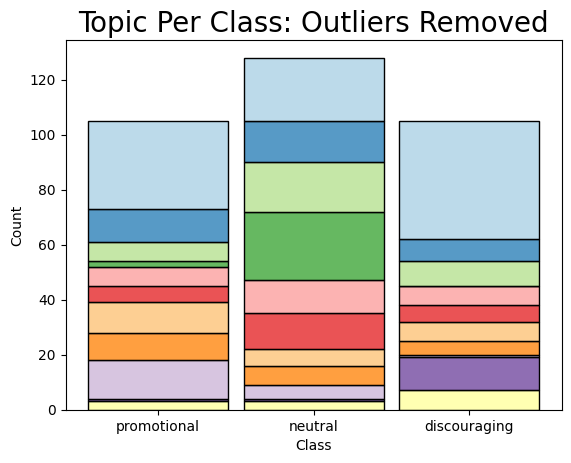

In [92]:
width = 0.8

ax = sns.histplot(topics_class_no_outliers, x='Class', hue='Topic', weights='Frequency', multiple='stack', palette = sns.color_palette("Paired"), shrink=.9)
ax.set_title("Topic Per Class: Outliers Removed", fontsize=20)
ax.legend("")
ax.get_legend().set_visible(False)

plt.savefig("TopicPerClassStacked_no_outliers.png")
files.download("TopicPerClassStacked_no_outliers.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

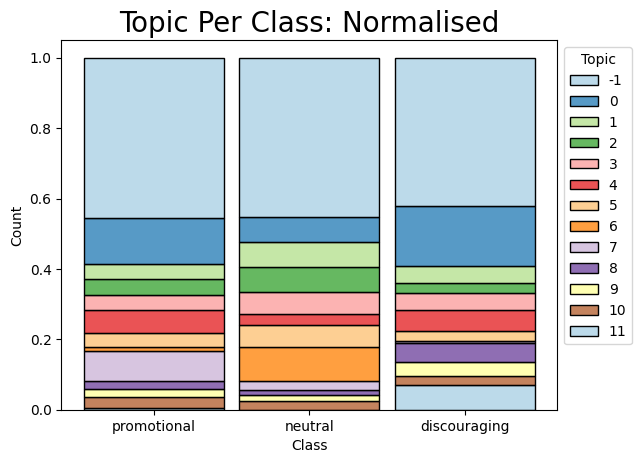

In [155]:
ax = sns.histplot(topics_class, x='Class', hue='Topic', weights='Frequency_Normalised', multiple='stack', palette = sns.color_palette("Paired"), shrink=.9)
ax.set_title("Topic Per Class: Normalised", fontsize=20)
#
#ax.get_legend().set_visible(False)
#ax.legend("")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig("TopicPerClassStacked_normalised.png")
files.download("TopicPerClassStacked_normalised.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

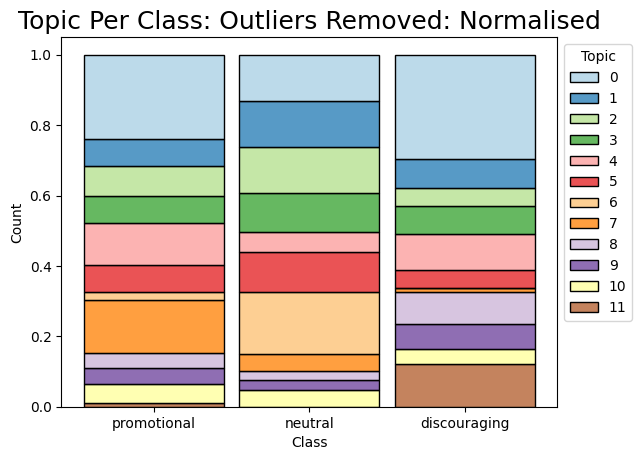

In [156]:
ax = sns.histplot(topics_class_no_outliers, x='Class', hue='Topic', weights='Frequency_Normalised', multiple='stack', palette = sns.color_palette("Paired"), shrink=.9)
ax.set_title("Topic Per Class: Outliers Removed: Normalised", fontsize=18)

#ax.get_legend().set_visible(False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig("TopicPerClassStacked_no_outliers_normalised.png")
files.download("TopicPerClassStacked_no_outliers_normalised.png")

In [95]:
topic_model.get_topic(8)

[('novax', 0.22720603657461577),
 ('no', 0.09650703428870704),
 ('vax', 0.08135923174696133),
 ('libert', 0.05622900640977697),
 ('far', 0.05115079432860612),
 ('tam', 0.04915768355331984),
 ('evitare', 0.04143088336476554),
 ('sti', 0.03989853874091355),
 ('essere', 0.03983954096633267),
 ('parte', 0.03650053895085107)]

In [96]:
topic_model.get_topic(7)

[('scolastico', 0.05544506781440649),
 ('scuole', 0.05544506781440649),
 ('insegnanti', 0.05544506781440649),
 ('pi', 0.05011418655824575),
 ('vaccinati', 0.04479203929878997),
 ('provateci', 0.03973018259788864),
 ('bambini', 0.03973018259788864),
 ('pediatra', 0.03973018259788864),
 ('vaccinato', 0.03886997627861776),
 ('famiglia', 0.03696337854293766)]

In [97]:
topic_model.get_topic(11)

False

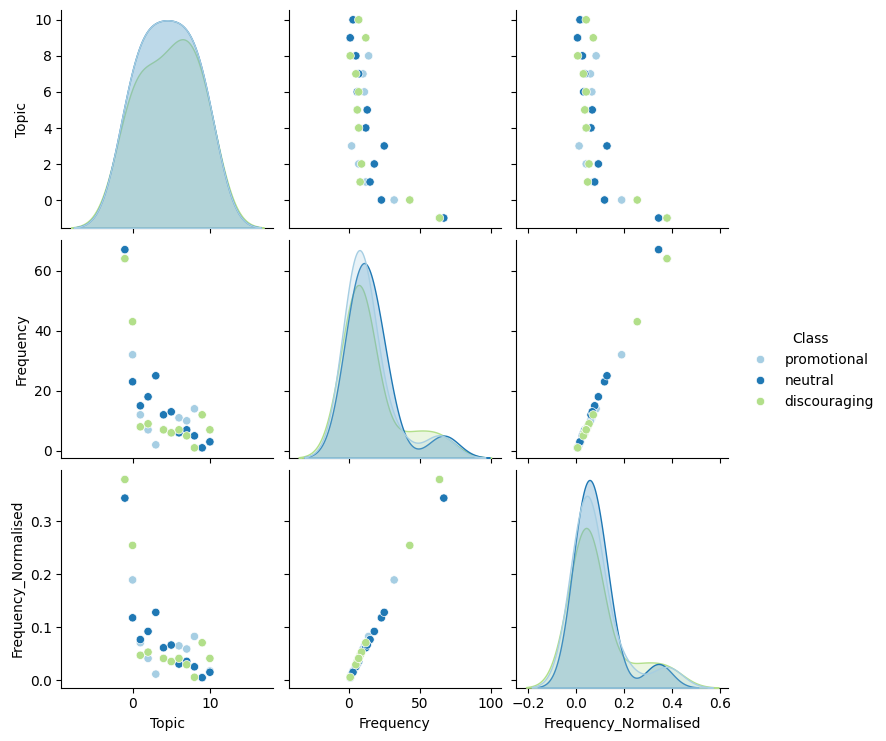

In [98]:
sns.pairplot(topics_class, hue ='Class')
plt.show()

In [99]:
topics_per_class = topic_model.topics_per_class(docs, classes)

topic_model.visualize_topics_per_class(topics_per_class,
    top_n_topics=10, normalize_frequency = True)

3it [00:00, 47.03it/s]


In [100]:
# https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640

# https://maartengr.github.io/BERTopic/getting_started/representation/llm.html#openai

In [101]:
#!pip install --upgrade plotly
import plotly.express as px

In [102]:
tmp_dfs = []
from tqdm import tqdm

# iterating through different threshold levels
for thr in np.arange(0, 0.025, 0.001):
    # calculating number of topics with probability > threshold for each document
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1

    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')

    # aggregating stats
    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr

    tmp_dfs.append(tmp_df_aggr)

num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold',
                              values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

# visualisation
colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df,
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of tweets, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      })

NameError: name 'topic_distr' is not defined

In [ ]:
#docs = data["data"]
#classes = [data["target_names"][i] for i in data["target"]]

# Create topic model and calculate topics per class
#topic_model = BERTopic()
#topics, probs = topic_model.fit_transform(docs)
#topics_per_class = topic_model.topics_per_class(docs, classes=classes)


In [ ]:
#topic_model.visualize_topics_per_class(topics_per_class)


In [ ]:
 total_data.head(2)

In [ ]:
# Create topics over time PER DAY

timestamps = data_dates.YearMonthDay.to_list()
tweets = data_dates.text.to_list()

model_day = BERTopic(language="italian",verbose=True)
topics, probs = model_day.fit_transform(tweets)
topics_over_time = model_day.topics_over_time(tweets, timestamps)

In [ ]:
model_day.visualize_topics_over_time(topics_over_time, top_n_topics=10)

In [ ]:
model_day.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4,5])


In [ ]:
topic_labels = model_day.generate_topic_labels(nr_words=2,
                                                 topic_prefix=False,
                                                 word_length=10,
                                                 separator=", ")

topic_labels

In [ ]:
sequence_to_classify =  " ".join([word for word, _ in model_day.get_topic(1)])
sequence_to_classify

In [ ]:
# Optimize labels
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

candidate_labels = ["promotional", "neutral", "discouraging"]
classifier(sequence_to_classify, candidate_labels)


In [ ]:
for i in range(10):
  sequence_to_classify =  " ".join([word for word, _ in model_day.get_topic(i)])
  print(sequence_to_classify)
  scores = classifier(sequence_to_classify, candidate_labels)
  print(scores["scores"])
  maxs = max(scores["scores"])
  print(maxs)



In [ ]:
model_day.visualize_barchart(custom_labels=True)

In [ ]:
# Create topics over time PER MONTH

timestamps = data_dates.YearMonth.to_list()
tweets = data_dates.text.to_list()

model_month = BERTopic(language="italian",verbose=True)
topics, probs = model_month.fit_transform(tweets)
topics_over_time = model_month.topics_over_time(tweets, timestamps)

model_month.visualize_topics_over_time(topics_over_time)

In [ ]:
model_month.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4,5])


In [ ]:
# Zero shot
from bertopic.representation import ZeroShotClassification

candidate_topics = ["promotional", "neutral", "discouraging"]
representation_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")

# Use the representation model in BERTopic on top of the default pipeline
topic_model_fb = BERTopic(representation_model=representation_model)


topics_fb, probs_fb = topic_model_fb.fit_transform(total_data_tweets)


In [ ]:
fig_fb = topic_model_fb.visualize_topics()
fig_fb.show()

In [ ]:
topic_model_fb.visualize_hierarchy(top_n_topics=5)

In [ ]:
topic_model.get_topic(0)

In [ ]:
topic_model.get_topic(1)

In [ ]:
topic_model.get_topic(3)